In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bbl_utils import *
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

In [3]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

In [4]:
dx = 500.
delta_t = 60.
diter = 28800

iter0 = 3182400
Niter = 22
dt = 1728000

iters = np.arange(iter0, iter0 + diter*Niter, diter)

In [5]:
diter_av = 144000
iter0_av = 3312000
Niter_av = 6
dt_av = 144000*60
iters_av = np.arange(iter0_av, iter0_av + diter_av*Niter_av, diter_av)

In [6]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_rest-tracer/run/"
dslev = open_mdsdataset(data_dir,iters=[3168720],ignore_unknown_vars=True,levels=[50, 70], prefix=["levelDiag"], delta_t=delta_t)
dsav = open_mdsdataset(data_dir,iters=iters_av,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [7]:
extend_multiples = [-1, 0]
xslice = [-3e5,3e5]

ds_list = []
grid_list = []
for ds in [dslev, dsav]:
    Lx = ds['XC'].size*dx
    ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
    ds = ds.sel(XC=slice(*xslice), XG=slice(*xslice))
    H = ds['Depth'].max().values.copy().astype('>f8')
    ds, grid = preprocess(ds, θ)
    ds['dV'] = (ds.drF * ds.rA * ds.hFacC)
    
    ds_list.append(ds)
    grid_list.append(grid)
    
dslev = ds_list[0]
dsav = ds_list[1]

In [8]:
ds = dslev
grid = grid_list[0]
ζ = (-grid.diff(ds.UVEL * ds.dxC, 'Y', boundary='fill')
     +grid.diff(ds.VVEL * ds.dyC, 'X', boundary='fill'))/ds.rAz
ζ = ζ.where(ζ!=0.)

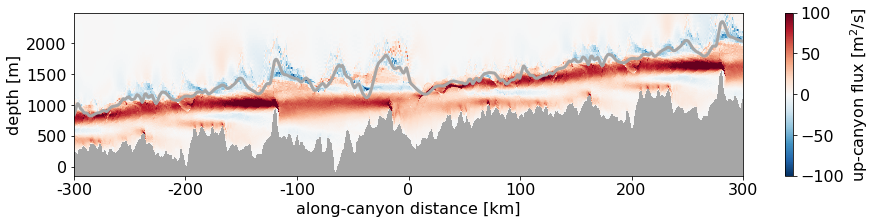

In [9]:
ds = dsav
Uflux = (ds['UVEL']*ds['dyG']).sum(dim='YC').mean(dim='time').compute()
Uflux = Uflux.where(Uflux!=0.)

plt.figure(figsize=(15,3))
plt.subplot(1,1,1, facecolor=nancol)
q = Uflux.plot(x='Xr_U', y='Zr_U')
q.set_clim([-100,100])
q.colorbar.set_label("up-canyon flux [m$^{2}$/s]")
(H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=3.0)
plt.ylim(-150, 2500)
plt.xlabel("along-canyon distance [km]")
plt.ylabel("depth [m]")
plt.yticks(np.arange(0, 2500, 500))
plt.xticks(np.arange(-300e3, 400e3, 100e3), np.arange(-300, 400, 100));
plt.savefig("../../figures/BBTRE/upcanyon_flow.png", dpi=100, bbox_inches="tight")

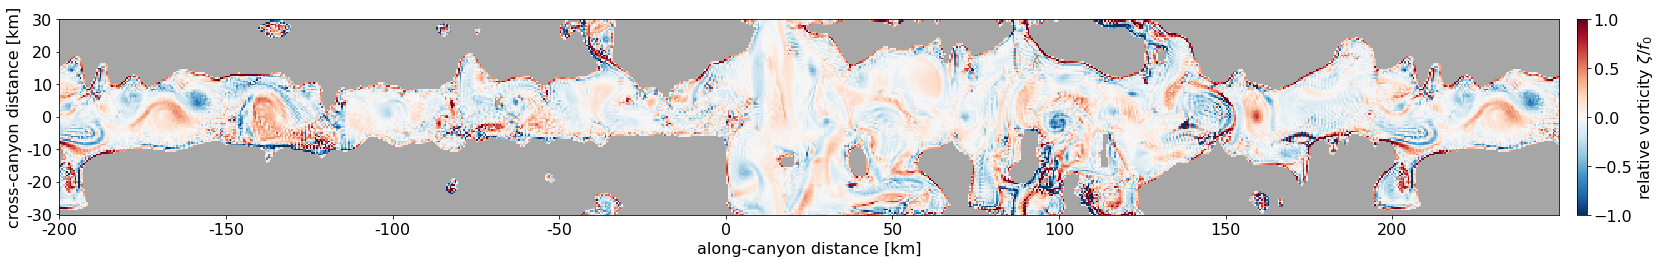

In [10]:

plt.figure(figsize=(32,3.6))
plt.subplot(1,1,1, facecolor=nancol)
q = (ζ/f).isel(time=0, Z=0).plot()
q.colorbar.remove()
plt.colorbar(q, pad=0.01, label=r"relative vorticity $\zeta / f_{0}$")
q.set_clim([-1,1])
plt.xlim([-200e3, 250e3])
plt.title("")
plt.xlabel("along-canyon distance [km]")
plt.ylabel("cross-canyon distance [km]")
plt.yticks(np.arange(0, 7.e4, 1.e4), np.arange(-30, 40, 10))
plt.xticks(np.arange(-2e5, 2.5e5, 0.5e5), np.arange(-200, 250, 50))

plt.savefig("../../figures/BBTRE/submesoscale_vorticity_field.png", dpi=100, bbox_inches="tight")